# Interacting with Sonifications
# The mesonic framework for interactive Auditory Data Science, ISon 2022
Supplementary Material for the paper

For all examples let's use the following includes to keep the code below compact:

In [1]:
import mesonic
import numpy as np
from pya import *
import matplotlib.pyplot as plt
from pyamapping import linlin, midicps, cpsmidi
import sc3nb as scn

Here we create a mesonic Context and activate the realtime mode.

In [2]:
context = mesonic.create_context()
context.enable_realtime();
context.processor.latency = 0.05
context.processor.latency

<IPython.core.display.Javascript object>

Starting sclang process... Done.
Registering OSC /return callback in sclang... Done.
Loading default sc3nb SynthDefs... Done.
Booting SuperCollider Server... Done.


0.05

## Basic Audification

In this example we will use the EEG data from the [Supplementary material for "sc3nb: a Python-SuperCollider Interface for Auditory Data Science"](https://doi.org/10.4119/unibi/2956379)

In [3]:
data = np.loadtxt("./files/epileptic-eeg.csv", delimiter=",")

We can simply create a stereo Buffer using this data

In [4]:
buf = context.buffers.from_data(data[:,[0,1]], sr=256)
buf

Buffer(2 x 25642 @ 256Hz = 50.082s)

And create a default Synth to play it back

In [5]:
bsyn = context.synths.from_buffer(buf)

In [6]:
bsyn # to see the synth's controls

Synth(sc3nb_playbuf_128, {'out': 0.0, 'bufnum': 128.0, 'rate': 1.0, 'loop': 0.0, 'pan': 0.0, 'amp': 0.3})

let's audify the data in a loop

In [7]:
bsyn.start(rate=20, amp=0.1, loop=1)

modify parameters interactively as needed

In [8]:
bsyn.rate = 5
bsyn.amp = 1

In [9]:
bsyn.stop()

## Interactive Audification

In [10]:
# load data to buffer
data = np.loadtxt("./files/epileptic-eeg.csv", delimiter=",")
buf = context.buffers.from_data(data[:,5], sr=256)
buf

Buffer(1 x 12821 @ 256Hz = 50.082s)

And create a default Synth to play it back

In [11]:
bsyn = context.synths.from_buffer(buf)

In [12]:
bsyn.start(rate=25)

Create a synth using TGrains for interactive scrubbing of the buffer

In [13]:
context.synths.buffer_synthdefs["tgrains"]= r"""
{ | bufnum={{BUFNUM}}, amp=0.3, rate=10, trate=5, pos=0 |
    var dur, cpos, sig;
    dur = 4 / trate;
    cpos = pos * BufDur.kr(bufnum);
    sig = TGrains.ar(2, Impulse.ar(trate), bufnum, rate, cpos, dur, 0, 0.5, 2);
    Out.ar(0, sig * amp);
}"""

In [14]:
tgsyn = context.synths.from_buffer(buf, synth_name="tgrains")
tgsyn

Synth(sc3nb_tgrains_129, {'bufnum': 129.0, 'amp': 0.3, 'rate': 10.0, 'trate': 5.0, 'pos': 0.0})

In [15]:
tgsyn.start()

In [16]:
%sc s.makeGui; s.scope

-> a Stethoscope


In [17]:
# set custom values
tgsyn.rate = 40
tgsyn.trate = 30
tgsyn.amp = 0.2
tgsyn.pos = 0

In [18]:
def explore_tgrain(trate=20, rate=50, pos=0, amp=0.5):
    tgsyn.rate = rate
    tgsyn.trate = trate
    tgsyn.pos = pos
    tgsyn.amp = amp
    
from ipywidgets import interactive, widgets
interactive(explore_tgrain, trate=(1,100,1), rate=(0.2,250,0.05), 
            pos=(0,1,0.001), amp=(0,1,0.01))

interactive(children=(IntSlider(value=20, description='trate', min=1), FloatSlider(value=50.0, description='ra…

In [19]:
tgsyn.stop()

Now let's couple interaction to a data plot

In [20]:
%matplotlib qt

In [21]:
from matplotlib.backend_bases import MouseButton
fig, ax = plt.subplots(figsize=(8,2))
asig = Asig(data[:,5], sr=256).plot()

tgsyn.start()

def on_click(event):
    if event.button is MouseButton.RIGHT:
        print('disconnecting callback')
        plt.disconnect(binding_id)

def on_move(event):
    # get the x and y pixel coords
    x, y = event.x, event.y
    if event.inaxes and event.button is MouseButton.LEFT:
        tgsyn.rate =  20 if event.ydata > 0 else 50
        tgsyn.pos = linlin(event.xdata, 0, 50, 0, 1)
    
cid = fig.canvas.mpl_connect('button_press_event', on_click)
binding_id = plt.connect('motion_notify_event', on_move)

Scrub left-right with pressed left Mouse button to explore the data.
- if you do it in the lower part of the plot, it will use rate 50
- if you do it in the upper part of the plot, if will use rate 20

In [22]:
tgsyn.stop()

## Minimal Parameter Mapping Sonification

In [23]:
s1i = context.synths.create("s1", mutable=False)
s2m = context.synths.create("s2", track=1)
print(s1i, "\n", s2m)

Synth(s1, {'freq': 400.0, 'amp': 0.3, 'num': 4.0, 'pan': 0.0, 'dur': 0.4, 'att': 0.01, 'curve': -2.0}) 
 Synth(s2, {'freq': 400.0, 'amp': 0.3, 'num': 4.0, 'pan': 0.0, 'lg': 0.1, 'gate': 1.0})


create a playback

In [24]:
context.disable_realtime();
pb = context.create_playback()

In [25]:
%matplotlib inline

In [26]:
context.reset()

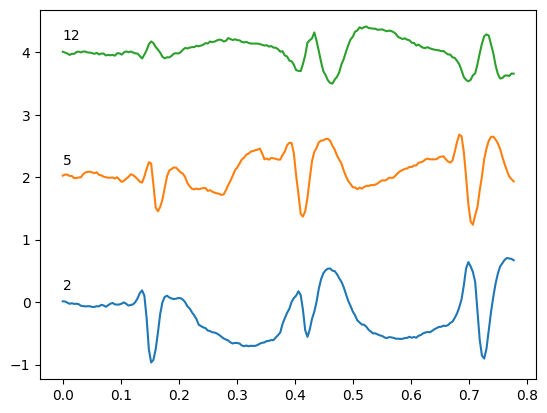

In [27]:
# parameters and plotting
duration = 5
nrows = 256
sel = slice(2100, 2356)
Asig(data[2000:2200,[2,5,12]], sr=256, cn=["2","5","12"]).plot(offset=2)

# start synth at time 0
with context.at(0): s2m.start()

# loop through data
for i, r in enumerate(data[2100:2100+nrows]):
    onset = linlin(i, 0, nrows, 0.02, duration)
    with context.at(onset): # context manager used to provide time 
        s2m.freq = linlin(r[5], -1, 1, 100, 400)        
        s2m.num = linlin(r[2], -1, 1, 1, 10)
        s2m.pan = linlin(r[12], -1, 1, -1, 1)  
        s2m.amp = 0.2

# stop synth at time duration
with context.at(duration): s2m.stop()

# playback sonification
pb.start(rate=1)

interact with playback while track plays, e.g. by changing playback rate

In [28]:
pb.rate = 0.5

### Discrete PMSon

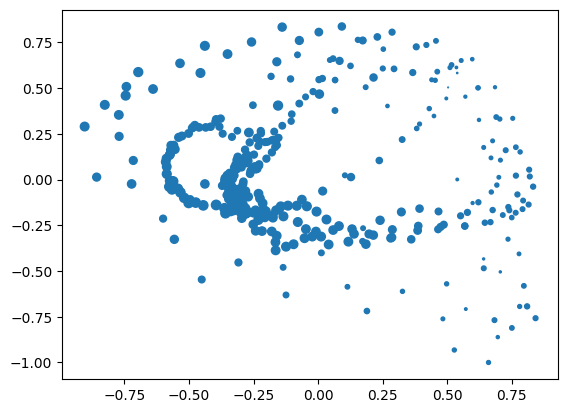

In [29]:
context.reset()
duration = 3
sel = slice(2100, 2456)
plt.scatter(data[sel, 2], data[sel, 5], s=50*data[sel, 12]+25.5)
for r in data[sel]:
    onset = linlin(r[2], -1, 1, 0, duration)
    with context.at(onset): # context manager is used to provide time 
        s1i.start(
            freq = midicps(linlin(r[5] , -1, 1,   50, 100)),        
            dur =          linlin(r[12], -1, 1, 0.01, 0.4) ,
            pan =          linlin(r[3] , -1, 1,   -1,   1) ,  
            amp = 0.05
        )

In [30]:
pb.start(rate=1)

In [31]:
pb.rate = -1 # execute this line towards the end to hear it being played backwards
pb

Playback(time=2.1936628818511963, rate=-1)

In [32]:
pb.stop()

In [33]:
context.reset()

## Interactive Continuous PMSon

In [34]:
%matplotlib qt

In [35]:
context.enable_realtime();

In [36]:
scn.SynthDef("dynklang", r"""
{ |out=0, f0=100, amp=0.1, freqs=#[1,2,3,4,5,6,7,8,9,10], amps=#[0,0,0,0,0,0,0,0,0,0]|
    Out.ar(out, amp * DynKlang.ar(`[freqs, amps, 0!10], freqscale: f0)!2);
}""").add()

'dynklang'

In [37]:
sdk = context.synths.create("dynklang")
sdk

Synth(dynklang, {'out': 0.0, 'f0': 100.0, 'amp': 0.1, 'freqs': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 'amps': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]})

In [38]:
# parameters and plotting
dim = 6 # dimension
ofs = 2 # offset for plotting 
sigma = 3  # bandwidth for amplitude filtering
sr = 256
dd = data[2000:2500,0:dim] # selected data for plot and sonification
Asig(dd, sr=sr).plot(offset=ofs)

# start synth at time 0
sdk.start(f0=180, amp=0, freqs=[1,2,3,4,5,6,7,8,9,10], amps=[1,1,1,1,1,1,1,1,1,1])

from matplotlib.backend_bases import MouseButton
def on_click(event):
    if event.button is MouseButton.LEFT:
        sdk.amp = 0.2

def on_release(event):
    if event.button is MouseButton.LEFT:
        sdk.amp = 0
        
def on_move(event):
    if event.inaxes and event.button is MouseButton.LEFT:
        vec = dd[int(event.xdata * sr), :dim]
        ampsvec = np.exp(-((event.ydata - np.arange(0, ofs*dim, ofs))/sigma)**2)
        sdk.amps = list(ampsvec)
        sdk.f0 = 1
        sdk.freqs = list(midicps( np.arange(dim)*10+40 + linlin(vec, -1, 1, -5, 5)))

cid1 = plt.gcf().canvas.mpl_connect('button_press_event', on_click)
cid2 = plt.connect('motion_notify_event', on_move)
cid3 = plt.gcf().canvas.mpl_connect('button_release_event', on_release)

def set_sigma(s=2): 
    global sigma
    sigma = s
from ipywidgets import interactive
interactive(set_sigma, s=(0.5,5,0.1))

interactive(children=(FloatSlider(value=2.0, description='s', max=5.0, min=0.5), Output()), _dom_classes=('wid…

In [39]:
sdk.stop()